In [1]:
magma_dir = '/home/marco/epfl/magma/'
cache_dir = None

#### AWS

In [2]:
magma_dir = '/home/ubuntu/magma/'
bucket_dir = '/home/ubuntu/s3/'
transformers_dir = '/home/ubuntu/transformers/'
cache_dir = bucket_dir+'.cache/'

### **Config**

In [3]:
import os
import sys

sys.path.insert(0, magma_dir)
import config

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [4]:
MODEL = 't5'
MODELS = {}

In [5]:
# Dataset path
data_dir = magma_dir + 'datasets/karger_books_para_wordembed/'+MODEL+'/'

# Output path
OUTPUT_PATH = magma_dir+'summarization/assign_bullets_para_wordembed/'+MODEL+'/'
if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)

#### AWS

In [6]:
data_dir = bucket_dir + 'datasets/karger_books_para_wordembed/'+MODEL+'/'

### **Init**

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import re
import pandas as pd
from tqdm import tqdm
from textwrap import fill
tqdm.pandas()

### **Function Definition**

##### Import Model and Tok

In [8]:
def import_model_tok(model_name_or_path, verbose=False):
    global MODELS

    if model_name_or_path in MODELS.keys():
        if verbose : print('[+] model already present in cache\n')
        return MODELS[model_name_or_path]
    if verbose : print('[*] importing the model\n')

    if 'bart' in MODEL:
        from transformers import BartForConditionalGeneration, BartTokenizer

        model = BartForConditionalGeneration.from_pretrained(model_name_or_path, cache_dir=cache_dir)
        tokenizer = BartTokenizer.from_pretrained(model_name_or_path, cache_dir=cache_dir)
    elif 'pegasus' in MODEL:
        from transformers import PegasusForConditionalGeneration, PegasusTokenizer

        model = PegasusForConditionalGeneration.from_pretrained(model_name_or_path, cache_dir=cache_dir)
        tokenizer = PegasusTokenizer.from_pretrained(model_name_or_path, cache_dir=cache_dir)
    elif 't5' in MODEL:
        from transformers import T5ForConditionalGeneration, T5Tokenizer

        model = T5ForConditionalGeneration.from_pretrained(model_name_or_path, cache_dir=cache_dir)
        tokenizer = T5Tokenizer.from_pretrained(model_name_or_path, cache_dir=cache_dir)

    if verbose : print(model.config)
    MODELS[model_name_or_path] = model, tokenizer
    if verbose : print('[+] the model is now present in cache\n')
    return MODELS[model_name_or_path]

##### Print Examples

In [9]:
def print_examples(model_name_list, df, n_examples=10):
    
    df_examples = df.sample(n_examples, axis='index', random_state=config.SEED)
    
    for idx, row in df_examples.iterrows():
        print(idx)
        print(fill(row.text, 100))
        print()
        for model_name in model_name_list:
            model, tokenizer = import_model_tok(model_name)
            model = model.to(device)
            
            summ_enc = model.generate(
                tokenizer.encode('summarize: '+row.text,
                    return_tensors='pt', truncation=True).to(device),
                min_length = config.ONE_BULLET_MIN_LEN,
                max_length = config.ONE_BULLET_MAX_LEN,
                length_penalty = config.LENGTH_PENALTY,
                num_beams = config.NUM_BEAMS,
                no_repeat_ngram_size = config.NO_REPEAT_NGRAM_SIZE,
                early_stopping = True)[0]
            summ_num_tok = len(summ_enc)
            summ = tokenizer.decode(summ_enc, skip_special_tokens=True)

            print('Prediction\n%s (%d tok):\n'%(model_name, summ_num_tok))
            print(fill(summ, 100))
            print()
            
        print('Reference:')
        print(fill(row.bullets, 100))
        print()
        print(''.join(['#']*100))
        print()

##### Plot Evaluation

In [10]:
def plot_evaluation_bullet_by_bullet(model_name_or_path):
    df = pd.read_csv(OUTPUT_PATH+model_name_or_path.replace('/', '?')+\
        '_bullet_by_bullet.csv').set_index(['book', 'chapter'])

    prf = ['precision', 'recall', 'fmeasure']
    num_rouge = len(config.ROUGE_TYPES)

    from matplotlib.cm import get_cmap
    color = get_cmap('tab10')(range(num_rouge))
    def set_box_color(b, c):
        for k in b.keys():
            plt.setp(b[k], color=c)
    
    xticks = 2*np.array(np.arange(1, num_rouge+3))
    
    box_plt_list = []

    fig, ax = plt.subplots(figsize=(10, 6))
    for r, var in zip(prf, np.linspace(-0.15*num_rouge, 0.15*num_rouge, num_rouge)):
    
        box_plt_list.append(
            plt.boxplot(
            [df[rouge+'_'+r].tolist() for rouge in config.ROUGE_TYPES],
            positions= xticks[:-2]+var,
            sym='+',
            widths=0.4,
            patch_artist=False,
            meanline=True,
            showmeans=True))
        
    box_plt_list.append(
        plt.boxplot(
        df['st_cosine_sim'].tolist(),
        positions=[xticks[-2]],
        sym='+',
        widths=0.4,
        patch_artist=False,
        meanline=True,
        showmeans=True))
    
    box_plt_list.append(
        plt.boxplot(
        df['w2v_cosine_sim'].tolist(),
        positions=[xticks[-1]],
        sym='+',
        widths=0.4,
        patch_artist=False,
        meanline=True,
        showmeans=True))

    for i, bp in enumerate(box_plt_list[:-2]):
        set_box_color(bp, color[i])
        plt.plot([], c=color[i], label=prf[i])
    plt.legend()

    ax.grid(True, axis='y', alpha=0.7, linestyle='--')
    ax.set_title('Evaluation Results', fontsize='xx-large')
    ax.set_ylabel('Rouge', fontsize='x-large')
    plt.xticks(xticks, config.ROUGE_TYPES+['ST Cosine', 'W2V Cosine'], fontsize='x-large')
    plt.show()

In [11]:
def plot_evaluation_grouping_bullets(model_name_or_path):
    df = pd.read_csv(OUTPUT_PATH+model_name_or_path.replace('/', '?')+\
        '_grouped.csv').set_index(['book', 'chapter'])

    prf = ['precision', 'recall', 'fmeasure']
    num_rouge = len(config.ROUGE_TYPES)

    from matplotlib.cm import get_cmap
    color = get_cmap('tab10')(range(num_rouge))
    def set_box_color(b, c):
        for k in b.keys():
            plt.setp(b[k], color=c)
    
    xticks = 2*np.array(np.arange(1, num_rouge+3))
    
    box_plt_list = []

    fig, ax = plt.subplots(figsize=(10, 6))
    for r, var in zip(prf, np.linspace(-0.15*num_rouge, 0.15*num_rouge, num_rouge)):
    
        box_plt_list.append(
            plt.boxplot(
            [df[rouge+'_'+r].tolist() for rouge in config.ROUGE_TYPES],
            positions= xticks[:-2]+var,
            sym='+',
            widths=0.4,
            patch_artist=False,
            meanline=True,
            showmeans=True))
    
    box_plt_list.append(
        plt.boxplot(
        df['st_cosine_sim'].tolist(),
        positions=[xticks[-2]],
        sym='+',
        widths=0.4,
        patch_artist=False,
        meanline=True,
        showmeans=True))
    
    box_plt_list.append(
        plt.boxplot(
        df['w2v_cosine_sim'].tolist(),
        positions=[xticks[-1]],
        sym='+',
        widths=0.4,
        patch_artist=False,
        meanline=True,
        showmeans=True))

    for i, bp in enumerate(box_plt_list[:-2]):
        set_box_color(bp, color[i])
        plt.plot([], c=color[i], label=prf[i])
    plt.legend()

    ax.grid(True, axis='y', alpha=0.7, linestyle='--')
    ax.set_title('Evaluation Results', fontsize='xx-large')
    ax.set_ylabel('Rouge', fontsize='x-large')
    plt.xticks(xticks, config.ROUGE_TYPES+['ST Cosine', 'W2V Cosine'], fontsize='x-large')
    plt.show()

## **Karger Books Para**

In [12]:
data_dir_st = data_dir + 'st/'

In [13]:
df_train = pd.read_csv(data_dir_st + 'train.csv').set_index(['book', 'chapter'])
df_val = pd.read_csv(data_dir_st + 'val.csv').set_index(['book', 'chapter'])
df_test = pd.read_csv(data_dir_st + 'test.csv').set_index(['book', 'chapter'])

### **Print and Summarization**

##### Print Train Examples

In [ ]:
print_examples([
    't5-large'],
    df_train)

##### Print Val Examples

In [ ]:
print_examples([
    't5-large'],
    df_val)

##### Print Test Examples

In [ ]:
print_examples([
    't5-large'],
    df_test)

##### Summarize Test

In [14]:
def summarize(model_name_or_path, df, batch_size):
    model, tokenizer = import_model_tok(model_name_or_path)
    model = model.to(device)
    
    text_list = ['summarize: '+t for t in df.text.tolist()]

    input_ids = tokenizer(text_list, return_tensors='pt', truncation=True, padding=True).input_ids
    input_ids = input_ids.split(batch_size)

    summs = []

    pbar = tqdm(total=len(input_ids), 
                position=0,
                leave=True,
                file=sys.stdout)
    for batch in input_ids:

        summ_enc = model.generate(
            batch.to(device),
            min_length = config.ONE_BULLET_MIN_LEN,
            max_length = config.ONE_BULLET_MAX_LEN,
            length_penalty = config.LENGTH_PENALTY,
            num_beams = config.NUM_BEAMS,
            no_repeat_ngram_size = config.NO_REPEAT_NGRAM_SIZE,
            early_stopping = True)
        summ = tokenizer.batch_decode(summ_enc, skip_special_tokens=True)
        summs += summ

        pbar.update(1)
    pbar.close()

    df['summary'] = summs
    
    df.to_csv(OUTPUT_PATH+model_name_or_path.replace('/', '?')+'.csv')
    
    return df

In [15]:
df_test = summarize('t5-large', df_test, 8)

100%|██████████| 31/31 [05:56<00:00, 11.50s/it]


### **Evaluation**

In [16]:
from datasets import load_metric

metric = load_metric("rouge")

from sentence_transformers import SentenceTransformer

sentence_distilroberta = SentenceTransformer('paraphrase-distilroberta-base-v1')

import gensim

#### Evaluate summaries bullet by bullet

In [17]:
def evaluate_model_bullet_by_bullet(model_name_or_path):
    df_eval = pd.read_csv(OUTPUT_PATH+model_name_or_path.replace('/', '?')+\
        '.csv').set_index(['book', 'chapter'])
    
    rouge_res =\
        df_eval[['bullets', 'summary']]\
        .apply(lambda row:
        metric.compute(
            predictions = [row[1]],
            references = [row[0]],
            rouge_types = config.ROUGE_TYPES,
            use_agregator = False), axis=1)
    for r in config.ROUGE_TYPES:
        for i, prf in enumerate(['precision', 'recall', 'fmeasure']):
            df_eval[r+'_'+prf] =\
                rouge_res.map(lambda score: 100*score[r][0][i])
    
    cosine_sim = lambda a, b: (np.dot(a, b) / (np.linalg.norm(a)*np.linalg.norm(b)))
    df_eval['st_cosine_sim'] =\
        df_eval[['bullets', 'summary']]\
        .apply(lambda row:
        100*cosine_sim(
            sentence_distilroberta.encode(row[1]),
            sentence_distilroberta.encode(row[0])), axis=1)
    
    def cosine_sim_w2v(s, b):
        s = gensim.utils.simple_preprocess(s, deacc=True)
        b = gensim.utils.simple_preprocess(b, deacc=True)
        corpus = [s, b]
        w2v = gensim.models.Word2Vec(
            corpus,
            min_count=1,
            sg=1,
            seed = config.SEED)
        s_embed = np.mean([w2v.wv[word] for word in s], axis=0)
        b_embed = np.mean([w2v.wv[word] for word in b], axis=0)
        return cosine_sim(s_embed, b_embed)
        
    df_eval['w2v_cosine_sim'] =\
        df_eval[['bullets', 'summary']]\
        .apply(lambda row:
        100*cosine_sim_w2v(row[1], row[0]), axis=1)
            
    df_eval.to_csv(OUTPUT_PATH+model_name_or_path.replace('/', '?')+'_bullet_by_bullet.csv')
    
    return df_eval

In [18]:
evaluate_model_bullet_by_bullet('t5-large')

bullets  \
book          chapter                                                      
9781910797631 chp6     The treatment rather than the prevention of de...   
              chp6     For milder forms of depression, self-help, rel...   
              chp6     There are a range of treatments that may be ef...   
              chp6     Selective serotonin-reuptake inhibitor antidep...   
              chp6     Depression is complex, and understanding and h...   
...                                                                  ...   
9781908541680 ch_4     Obesity significantly affects cardiometabolic ...   
              ch_4     Lipid disorders and hypertension are exacerbat...   
              ch_4     Weight loss rapidly and effectively reduces ca...   
              ch_4     The metabolic syndrome defines the clustering ...   
              ch_4     Type 2 diabetes mellitus is the comorbidity mo...   

                                                                    text  \
book          chapter                                                      
9781910797631 chp6     Prevention and management. By far the most res...   
              chp6     Psychological or pharmacological therapy? Many...   
              chp6     The effectiveness of individual treatments is ...   
              chp6     Monitoring use of antidepressants. For people ...   
              chp6     Suicidal ideas and acts may be increased in th...   
...                                                                  ...   
9781908541680 ch_4     Overweight/obesity as a whole predisposes to, ...   
              ch_4     Overweight/obesity as a whole predisposes to, ...   
              ch_4     Overweight/obesity as a whole predisposes to, ...   
              ch_4     'Metabolic syndrome' describes the clustering ...   
              ch_4     Type 2 diabetes mellitus is a preventable dise...   

                       num_bulls  \
book          chapter              
9781910797631 chp6          2319   
              chp6          2319   
              chp6          2319   
              chp6          2319   
              chp6          2319   
...                          ...   
9781908541680 ch_4          2556   
              ch_4          2556   
              ch_4          2556   
              ch_4          2556   
              ch_4          2556   

                                                                 summary  \
book          chapter                                                      
9781910797631 chp6     prevention strategies may be directed toward t...   
              chp6     many people prefer psychological treatments to...   
              chp6     the effectiveness of individual treatments is ...   
              chp6     monitoring use of antidepressants is warranted...   
              chp6     suicidal ideas and acts may be increased in th...   
...                                                                  ...   
9781908541680 ch_4     overweight/obesity as a whole predisposes to, ...   
              ch_4     overweight/obesity as a whole predisposes to, ...   
              ch_4     overweight/obesity as a whole predisposes to, ...   
              ch_4     'Metabolic syndrome' describes clustering of r...   
              ch_4     a modest reduction in weight by intensive life...   

                       rouge1_precision  rouge1_recall  rouge1_fmeasure  \
book          chapter                                                     
9781910797631 chp6            18.181818      14.285714        16.000000   
              chp6            32.352941      22.916667        26.829268   
              chp6            27.500000      34.375000        30.555556   
              chp6            16.129032      20.000000        17.857143   
              chp6            21.428571      36.000000        26.865672   
...                                 ...            ...              ...   
9781908541680 ch_4           

#### Evaluate summaries grouping bullets

In [19]:
def evaluate_model_grouping_bullets(model_name_or_path):
    df_eval = pd.read_csv(OUTPUT_PATH+model_name_or_path.replace('/', '?')+\
        '.csv').set_index(['book', 'chapter'])
    
    df_eval = df_eval.groupby(['book', 'chapter'], sort=False).agg({
        'text': lambda t: ' '.join(list(t)),
        'bullets': lambda b: ' '.join(list(b)),
        'summary': lambda s: ' '.join(list(s))})
    
    rouge_res =\
        df_eval[['bullets', 'summary']]\
        .apply(lambda row:
        metric.compute(
            predictions = [row[1]],
            references = [row[0]],
            rouge_types = config.ROUGE_TYPES,
            use_agregator = False), axis=1)
    for r in config.ROUGE_TYPES:
        for i, prf in enumerate(['precision', 'recall', 'fmeasure']):
            df_eval[r+'_'+prf] =\
                rouge_res.map(lambda score: 100*score[r][0][i])
            
    cosine_sim = lambda a, b: (np.dot(a, b) / (np.linalg.norm(a)*np.linalg.norm(b)))
    df_eval['st_cosine_sim'] =\
    df_eval[['bullets', 'summary']]\
        .apply(lambda row:
        100*cosine_sim(
            sentence_distilroberta.encode(row[1]),
            sentence_distilroberta.encode(row[0])), axis=1)
    
    def cosine_sim_w2v(s, b):
        s = gensim.utils.simple_preprocess(s, deacc=True)
        b = gensim.utils.simple_preprocess(b, deacc=True)
        corpus = [s, b]
        w2v = gensim.models.Word2Vec(
            corpus,
            min_count=1,
            sg=1,
            seed = config.SEED)
        s_embed = np.mean([w2v.wv[word] for word in s], axis=0)
        b_embed = np.mean([w2v.wv[word] for word in b], axis=0)
        return cosine_sim(s_embed, b_embed)
        
    df_eval['w2v_cosine_sim'] =\
        df_eval[['bullets', 'summary']]\
        .apply(lambda row:
        100*cosine_sim_w2v(row[1], row[0]), axis=1)
            
    df_eval.to_csv(OUTPUT_PATH+model_name_or_path.replace('/', '?')+'_grouped.csv')
    
    return df_eval

In [20]:
evaluate_model_grouping_bullets('t5-large')

,,text,bullets,summary,rouge1_precision,rouge1_recall,rouge1_fmeasure,rouge2_precision,rouge2_recall,rouge2_fmeasure,rougeL_precision,rougeL_recall,rougeL_fmeasure,st_cosine_sim,w2v_cosine_sim
book,chapter,,,,,,,,,,,,,,
9781910797631,chp6,Prevention and management. By far the most res...,The treatment rather than the prevention of de...,prevention strategies may be directed toward t...,33.333333,34.883721,34.090909,2.793296,2.923977,2.857143,16.111111,16.860465,16.477273,73.376536,86.555332
9781910797426,ch03,Epidemiology and risk factors. Gallstones are ...,The prevalence of gallstones is greater in peo...,gallstones are a significant cause of morbidit...,42.777778,60.156250,50.000000,16.201117,22.834646,18.954248,25.000000,35.156250,29.220779,83.358705,85.110313
9781908541277,ch_12,Nearly 1 in 3 patients reports significant con...,Depression and anxiety are common in patients ...,depression is the most prevalent psychiatric c...,36.575875,63.087248,46.305419,15.625000,27.027027,19.801980,22.957198,39.597315,29.064039,71.554506,91.631562
9781910797907,chp6,When to transfuse. There is no set standard wi...,The decision for transfusion therapy relates t...,there is no set standard with regard to transf...,40.740741,50.381679,45.051195,15.527950,19.230769,17.182131,27.777778,34.351145,30.716724,88.736564,75.956440
9781908541277,ch_8,Modern antiepileptic drugs. After a hiatus of ...,Sixteen new antiepileptic drugs (AEDs) have be...,"after a hiatus of nearly 20 years, 16 new AEDs...",18.045113,46.153846,25.945946,5.303030,13.725490,7.650273,13.533835,34.615385,19.459459,68.072259,55.097783
9781910797006,ch08,Acute exacerbations of chronic obstructive pul...,Acute exacerbations of COPD are common and pla...,acute exacerbations of chronic obstructive pul...,22.131148,60.674157,32.432432,7.818930,21.590909,11.480363,14.344262,39.325843,21.021021,71.699858,85.527247
9781910797105,ch06,Morphological findings. MRI studies confirmed ...,People with schizophrenia exhibit gray matter ...,MRI studies demonstrated for the first time th...,21.212121,47.572816,29.341317,8.260870,18.627451,11.445783,13.419913,30.097087,18.562874,84.219027,86.005372
9783318068207,hh-5,The recent improvements in terms of available ...,Comprehensive genomic profiles offer a complet...,CGP offers a complete evaluation of the genomi...,41.071429,56.557377,47.586207,19.760479,27.272727,22.916667,28.571429,39.344262,33.103448,81.747437,86.782646
9781910797105,ch04,Studies in twins involve probands with schizop...,Identical twins show a 45% concordance rate. H...,studies in twins involve probands with schizop...,19.387755,53.521127,28.464419,3.076923,8.571429,4.528302,10.204082,28.169014,14.981273,80.017912,79.887724


#### Plot evaluation bullet by bullet

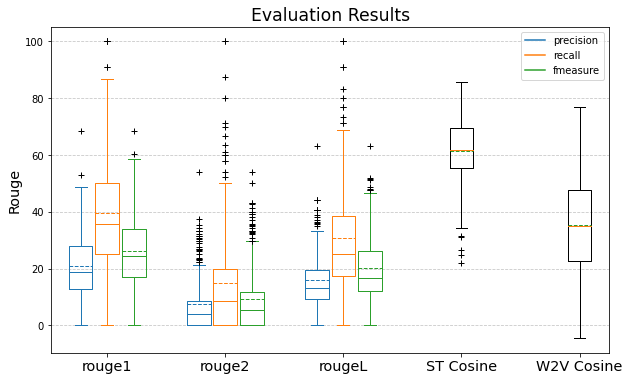

In [21]:
plot_evaluation_bullet_by_bullet('t5-large')

#### Plot evaluation grouping bullets

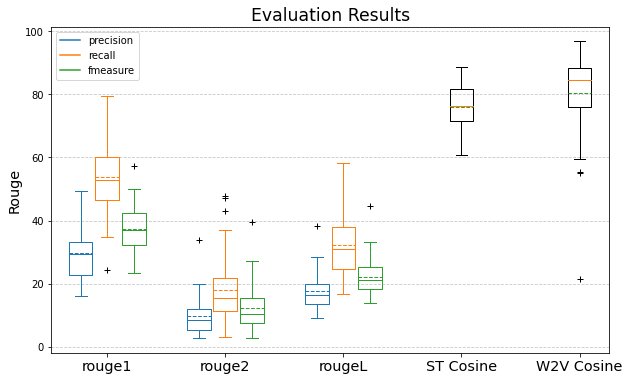

In [22]:
plot_evaluation_grouping_bullets('t5-large')